In [ ]:
import numpy as np
import cv2
from imageio import imread, imsave
from skimage import color
import matplotlib.pyplot as plt
import plotly.graph_objects as go

%matplotlib inline

# Part 1: Structure from motion

First we write the required functions to be used in the 4 problems in this part, as required. Comments have been used to explain the procedure in these functions.

In [ ]:
def sampson_distance(F, x1, x2):
    # Compute sampson error for each correspondence.

    Fx1 = np.dot(F, x1)
    Fx2 = np.dot(F, x2)
    denom = Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2
    
    # return error per point
    return (np.diag(np.dot(x1.T, np.dot(F,x2))))**2/denom

def compute_epipole(F):
    """ Computes the (right) epipole from a
    fundamental matrix F.
    (Use with F.T for left epipole.) """
    
    # Fe_1 = 0, thus need to return null space of F (Fx = 0)
    u, s, vh = np.linalg.svd(F, full_matrices=True)
    return vh[-1]/vh[-1][2]

def plot_epipolar_line(im, F, x, epipole=None, show_epipole=True, start=0):
    """ Plot the epipole and epipolar line F*x=0
        in an image. F is the fundamental matrix 
        and x a point in the other image."""
    
    m,n = im.shape[:2]
    line = np.dot(F,x)
    
    # epipolar line parameter and values
    t = np.linspace(start,n,100)
    lt = np.array([(line[2]+line[0]*tt)/(-line[1]) for tt in t])

    # take only line points inside the image
    ndx = (lt>=0) & (lt<m) 
    plt.plot(t[ndx],lt[ndx],linewidth=2)
    
    if show_epipole:
        if epipole is None:
            epipole = compute_epipole(F)
        plt.plot(epipole[0],epipole[1],'r*')


def compute_fundamental(x1,x2):
    """ Computes the fundamental matrix from corresponding points
    (x1,x2 3*n arrays) using the normalized 8 point algorithm.
    each row is constructed as
    [x’*x, x’*y, x’, y’*x, y’*y, y’, x, y, 1] """
    
    W = np.zeros([0,9])
    for p in range(x1.shape[1]):
        W = np.vstack([W, np.array([x1[0,p]*x2[0,p], x1[0,p]*x2[1,p], x1[0,p]*x2[2,p], x1[1,p]*x2[0,p], x1[1,p]*x2[1,p],
                                    x1[1,p]*x2[2,p], x1[2,p]*x2[0,p], x1[2,p]*x2[1,p], x1[2,p]*x2[2,p]])])

    u,s,vh = np.linalg.svd(W)
    fmat = vh[-1].reshape(3,3)

    u,s,vh = np.linalg.svd(fmat)
    s[2] = 0
    fmat = u@np.diag(s)@vh
    return fmat/fmat[2,2]


def compute_fundamental_normalized(x1,x2):
    """ Computes the fundamental matrix from corresponding points 
        (x1,x2 3xn arrays) using the normalized 8 point algorithm. """

    # normalize image coordinates
    x1n = x1/x1[2]
    x2n = x2/x2[2]
    
    scale1 = np.sqrt(2)/np.std(x1n[:2])
    t1 = np.array([[scale1,0,-scale1*np.mean(x1n[:2], 1)[0]],[0,scale1,-scale1*np.mean(x1n[:2], 1)[1]],[0,0,1]])
    scale2 = np.sqrt(2)/np.std(x2n[:2])
    t2 = np.array([[scale2,0,-scale2*np.mean(x2n[:2], 1)[0]],[0,scale2,-scale2*np.mean(x2n[:2], 1)[1]],[0,0,1]])

    # compute F with the normalized coordinates
    fnormalized = compute_fundamental(t1@x1n, t2@x2n)

    # denormalization
    fnormalized = t1.T@fnormalized@t2
    return fnormalized/fnormalized[2,2]


def skew(a):
    """ Skew matrix A such that a x v = Av for any v. """
    return np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])


def make_homog(points):
    return np.vstack((points, np.ones((1, points.shape[1]))))


def triangulate(x1, x2, P1, P2):
    """    
    Two-view triangulation of points in x1,x2 (3xn homog. coordinates). 
    Return: 3xn point cloud
    """
    ptcloud = np.empty([0,4])
    
    for i in range(x1.shape[1]):
        mat = np.zeros((6,6))
        mat[0:3,0:4] = P1
        mat[3:,0:4] = P2
        mat[0:3,4] = -x1[:,i]
        mat[3:,5] = -x2[:,i]

        u,s,vh = np.linalg.svd(mat)
        newvec = vh[-1,:4]
        ptcloud = np.vstack([ptcloud, newvec/newvec[3]])
    
    return ptcloud.T


def extract_correspondences_knn(im1, im2, coeff = 0.5):
    """    
    Since both ORB and SIFT are creating too few good corrrespondances, I used
    AKAZE, and used Hamming distance instead of L_2 distance, to get a lot more
    good correspondances.
    """
    orb = cv2.AKAZE_create()
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)

    kp1, desc1 = orb.detectAndCompute(im1, None)
    kp2, desc2 = orb.detectAndCompute(im2, None)

    matches = bf.knnMatch(desc1, desc2, 2)

    # Apply ratio test with parameter 'coeff', to obtain good correspondances
    matches_for_plot = []
    for m, n in matches:
        if m.distance < coeff*n.distance:
            matches_for_plot.append([m])
            
    # Extracting points corresponding to good matches (in matches_for_plot)
    pts1 = np.float32([kp.pt for kp in kp1])
    pts2 = np.float32([kp.pt for kp in kp2])
    pts1 = np.float32([pts1[m[0].queryIdx] for m in matches_for_plot])
    pts2 = np.float32([pts2[m[0].trainIdx] for m in matches_for_plot])
            
    return pts1, pts2, matches_for_plot, kp1, kp2

## Problem 1

Here I have extracted the correspondances using KNN, which is different from my Pset4 implementation. However, I noticed that both SIFT and ORB were giving me very few matches, that too many were bad matches. Hence I used AKAZE, which gave thousands of much better quality matches, and used the parameter `coeff` to denote the coefficient used in ratio test to compare the goodness of the matches. The lower the value of coeff, the lesser the number of matches (and higher the quality of the matches).

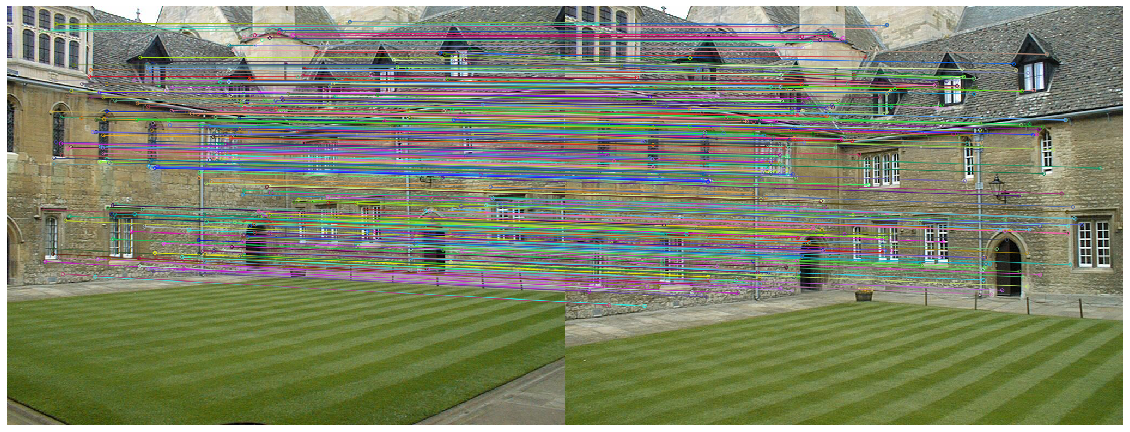

In [ ]:
merton1 = imread("data/merton1.jpg")
merton2 = imread("data/merton2.jpg")

pts1, pts2, matches_for_plot, kp1, kp2 = extract_correspondences_knn(merton1, merton2, coeff = 0.5)

img3 = cv2.drawMatchesKnn(merton1,kp1, merton2, kp2, matches_for_plot,
                       None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img3)
plt.show()

## Problem 2

Here I have simply run the codes for the `sampson_distance`, `compute_fundamental`, and `compute_fundamental_normalized` written before Problem 1, using the 8 point algorithm and its normalized variant. We see that the median and mean values of the sampson error for the non-normalized case, is around 28 and 152 respectively, which are pretty high. However, using the normalized fundamental matrix decreased the median sampson error to less than 5 pixels (which is pretty remarkable). Even the mean sampson error saw a 10 fold decrease for the normalized case.

In [ ]:
# Sampson error
x1 = make_homog(pts1.T)
x2 = make_homog(pts2.T)

F = compute_fundamental(x1, x2)
F_normalized = compute_fundamental_normalized(x1, x2)

error = sampson_distance(F, x1, x2)
print("Median Sampson error for non-normalized case: {}".format(np.median(error)))
print("Average Sampson error for non-normalized case: {}\n".format(np.mean(error)))

error = sampson_distance(F_normalized, x1, x2)
print("Median Sampson error for normalized case: {}".format(np.median(error)))
print("Average Sampson error for normalized case: {}".format(np.mean(error)))

Median Sampson error for non-normalized case: 28.706049056157553
Average Sampson error for non-normalized case: 152.2752426910164

Median Sampson error for normalized case: 4.971032800100171
Average Sampson error for normalized case: 15.169394069107511


## Problem 3

Here we have plotted the epipolar lines and epipoles using the helper function `plot_epipolar_line` and the written function `compute_epipole`, which was pretty straightforward.

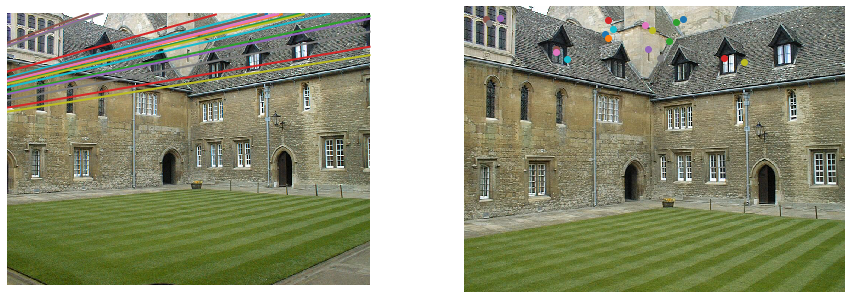

In [ ]:
# Epiline plotting
rand_ind = np.random.permutation(pts2.shape[0])

e = compute_epipole(F)

plt.figure(1, figsize=(15,10))
plt.subplot(121)
plt.axis('off')
plt.imshow(merton1)

for i in range(20):
    x = make_homog(pts1.T).T[rand_ind[i],:]
    plot_epipolar_line(merton1, F, x2[:,i], e, False)

plt.subplot(122)
 
plt.axis('off')
plt.imshow(merton2)

for i in range(20):
    plt.plot(x2[0,i],x2[1,i],'o')

plt.show()

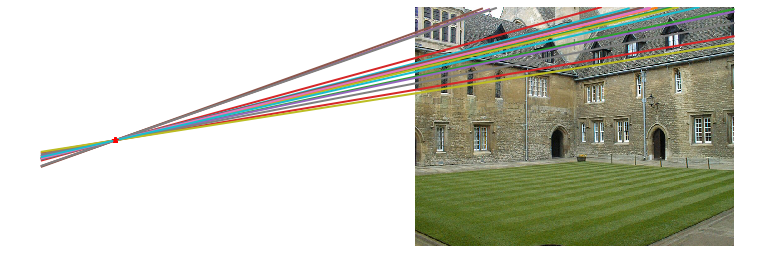

In [ ]:
# Epipole plotting
plt.figure(1, figsize=(30,20))

plt.subplot(122)
plt.axis('off')
plt.imshow(merton1)

plt.figure(1, figsize=(15,10))

e = compute_epipole(F.T)

for i in range(20):
    x = make_homog(pts1.T).T[rand_ind[i],:]
    plot_epipolar_line(merton1, F, x2[:,i], e, True, start=-1200)

plt.show()

## Problem 4

I have implemented the code for the triangulation in the functions written before Problem 1. However, for the `coeff` value of 0.5, I was not getting a clear L shaped point cloud, so I included more low-confidence AKAZE matches by increasing the `coeff` value to 0.8, and got a reasonable L-shaped point cloud. I have used plotly to plot the point cloud, but in case it is not cached properly, I have also included a screenshot showing the clear L-shape. Hopefully that will be enough.

In [ ]:
# Triangulation
P1 = np.loadtxt("data/001.P")
P2 = np.loadtxt("data/002.P")

pts1, pts2, match_for_plot, kp1, kp2 = extract_correspondences_knn(merton1, merton2, coeff=0.8)

x1 = make_homog(pts1.T)
x2 = make_homog(pts2.T)

colors = []
for i in range(pts1.shape[0]):
    u, v = pts1[i,:]
    colors.append(merton1[int(v), int(u), :]/255.)
    
colors = np.array(colors)
x, y, z = triangulate(x1, x2, P1, P2)[:3,:]
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode = 'markers', marker=dict(size=0.6, color=colors))])

camera = dict(
    eye=dict(x=0.8, y=-0.05, z=0.)
)

fig.update_layout(scene_camera=camera)
fig.show()

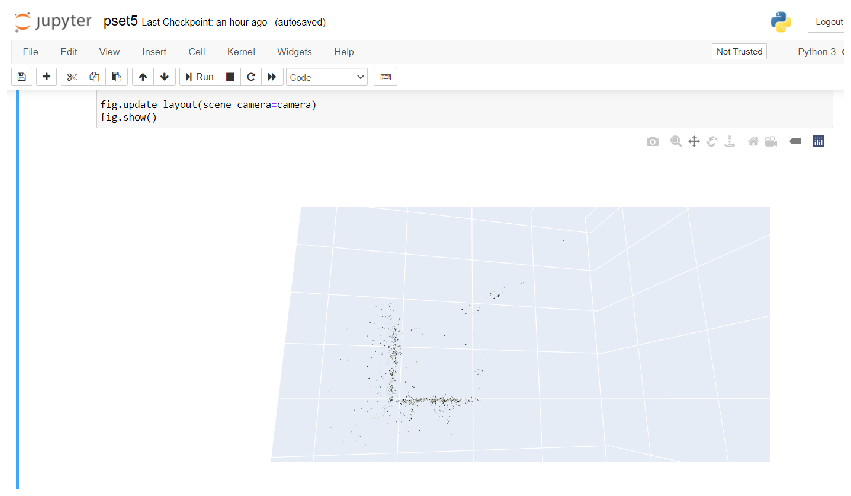

In [ ]:
Lshape = imread("plotly_Lshape.png")

plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(Lshape)
plt.show()

# Part 2: Image Segmentation

## Problem 5

In this problem we write the finction `dist5d` that takes two 5-dimensional vectors, i.e. vectors of labxy values, and calculates the value of $D_s\ =\ d_{lab}\ +\ \frac{m}{S}d_{xy}$, as mentioned in the paper.

In [ ]:
# Calculating 5d distance as given in paper
def dist5d(labxy1, labxy2, S, m):
    return np.linalg.norm((labxy1 - labxy2)[:3]) + (m/S)*np.linalg.norm((labxy1 - labxy2)[3:])

The 5d distance between 2 vectors increases as we increase $m$. This means that in the pixel assignent process, the algorithm will tend to not assign pixels that are farther away (from an euclidean sense) from the cluster center. In other words, larger the value of the compactness parameter $m$, the more the emphasis on spatial vicinity, hence the more compact the cluster is. We do observe the same, in the outputs of the next problem.


## Problem 6

In the next cell, I have written a class `superpixel` that will mainly be used to update the labxy coordinates of its cluster centre, plus pixels assigned to it. I have also implemented a `pixel_assignment` function that assigns the correct pixels to the corresponding clusters based on the 5d distance defined in the previous problem, as mentioned in the problem 5. The actual paper on SLIC_Superpixels had a much more complicated implementation than the one described in the problem set, as it had a part where it used gradients to perturb cluster centers to points of lowest gradient in the immediate neighbourhood. I have written that code as well (and put it here as well, in case I am graded on it), but not used it in the SLIC function since even without using it I am getting decent enough results.

In [ ]:
# Superpixel class for ease of updating labxy coordinates
class superpixel(object):
    def __init__(self, l, a, b, x, y):
        self.update(l, a, b, x, y)
        self.pixels = []

    def update(self, l, a, b, x, y):
        self.l = l
        self.a = a
        self.b = b
        self.x = x
        self.y = y
        

"""
# function to calculate gradient at each pixel (Unused in my implementation)
def gradient(img, y, x):
    img_height, img_width = img.shape[0], img.shape[1]
    x = img_width - 2 if x + 1 >= img_width else x
    y = img_width - 2 if y + 1 >= img_width else y

    return (img[y+1, x+1][0] - img[y, x][0] + img[y+1, x+1][1] - img[y, x][1] + img[y+1, x+1][2] - img[y, x][2])
"""


# Pixel assignment to correct cluster via 5d distance
def pixel_assignment(cluster_list, S, m, img, distances, tagged):
    img_height, img_width = img.shape[0], img.shape[1]

    for cluster in cluster_list:
        for y in range(max([cluster.y - 2*S, 0]), min([cluster.y + 2*S, img_height - 1])):
            for x in range(max([cluster.x - 2*S, 0]), min([cluster.x + 2*S, img_width - 1])):

                D_s = dist5d(np.hstack([img[y, x], np.array([x, y])]),\
                             np.array([cluster.l, cluster.a, cluster.b, cluster.x, cluster.y]), S, m)
                if D_s < distances[y, x]:
                    if (y, x) not in tagged:
                        tagged[(y, x)] = cluster
                        cluster.pixels.append((y, x))
                    else:
                        tagged[(y, x)].pixels.remove((y, x))
                        tagged[(y, x)] = cluster
                        cluster.pixels.append((y, x))
                    distances[y, x] = D_s

Below is my implementation of SLIC. I have an extra parameter, i.e. `maxiter` which is the maximum number of iterations of the pixel assignment algorithm. Since it was taking a lot of time to run, I have just used 7 iterations, which was actually good enough to give very good results. I have also blackened the cluster centres to make it look like the expected output image in the problem set. I have output 9 images, with the values $k\in\{100,\ 200,\ 300\}$ and  $m\in\{10,\ 20,\ 40\}$.

In [ ]:
# Implementation of main function "SLIC"
def SLIC(path, k, m, maxiter):
    img = color.rgb2lab(imread(path))
    img_height, img_width = img.shape[0], img.shape[1]

    S = int(np.sqrt(img_height*img_width/k))
    distances = np.full((img_height, img_width), np.inf)
    cluster_list = []
    tagged = {}

    # Initialising the superpixels
    y = S//2
    x = S//2
    while y < img_height:
        while x < img_width:
            cluster_list.append(superpixel(img[y, x][0], img[y, x][1], img[y, x][2], x, y))
            x += S
        x = S//2
        y += S

    # Run till maximum number of iterations
    for iter in range(maxiter):
        pixel_assignment(cluster_list, S, m, img, distances, tagged)
        for cluster in cluster_list:
            ysum = xsum = num = 0
            for pixel in cluster.pixels:
                ysum += pixel[0]
                xsum += pixel[1]
                num += 1
                cluster.update(img[ysum//num, xsum//num][0], img[ysum//num, xsum//num][1],\
                               img[ysum//num, xsum//num][2], xsum//num, ysum//num)

    # Final construction of the image, and blackening of cluster centres
    img_copy = np.copy(img)
    for cluster in cluster_list:
        for pixel in cluster.pixels:
            img_copy[pixel[0], pixel[1]] = np.array([cluster.l, cluster.a, cluster.b])
        img_copy[cluster.y, cluster.x] = np.array([0,0,0])
        
    return color.lab2rgb(img_copy)

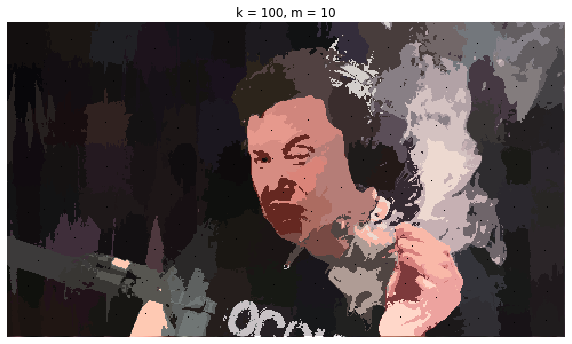

In [ ]:
k100m10 = SLIC(path = 'data/elon.png', k = 100, m = 10, maxiter = 7)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("k = 100, m = 10")
plt.imshow(k100m10)

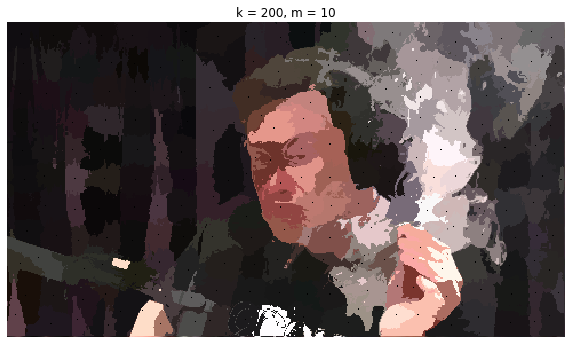

In [ ]:
k200m10 = SLIC(path = 'data/elon.png', k = 200, m = 10, maxiter = 7)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("k = 200, m = 10")
plt.imshow(k200m10)

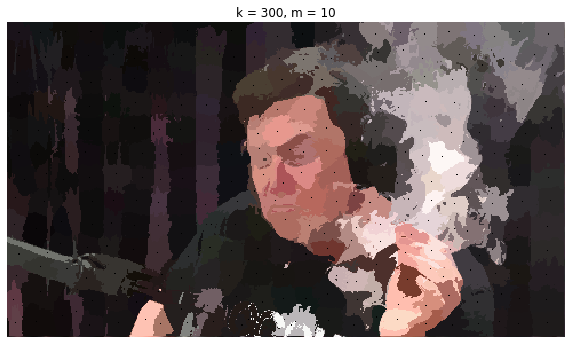

In [ ]:
k300m10 = SLIC(path = 'data/elon.png', k = 300, m = 10, maxiter = 7)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("k = 300, m = 10")
plt.imshow(k300m10)

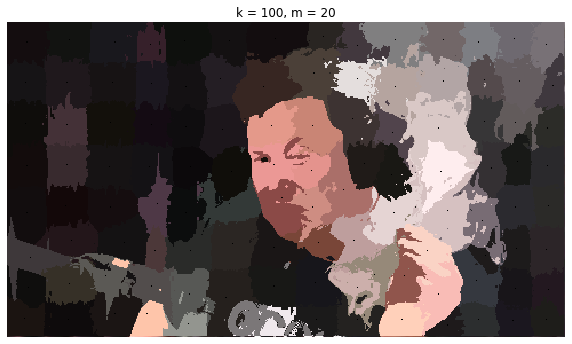

In [ ]:
k100m20 = SLIC(path = 'data/elon.png', k = 100, m = 20, maxiter = 7)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("k = 100, m = 20")
plt.imshow(k100m20)

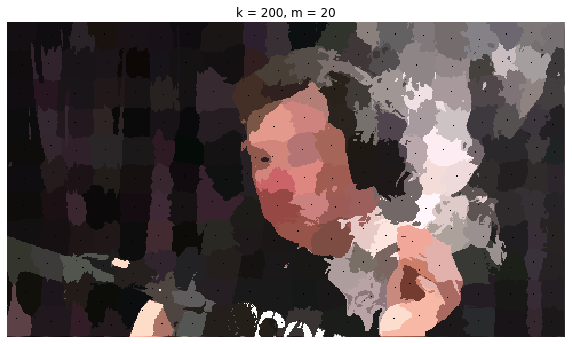

In [ ]:
k200m20 = SLIC(path = 'data/elon.png', k = 200, m = 20, maxiter = 7)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("k = 200, m = 20")
plt.imshow(k200m20)

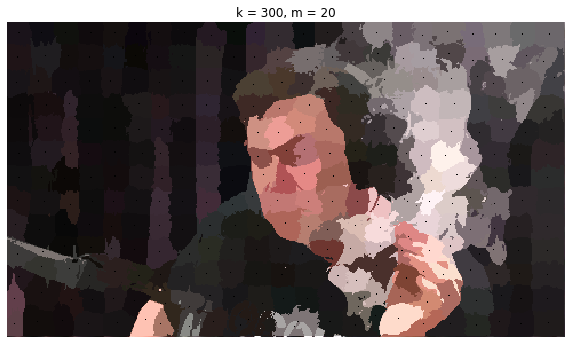

In [ ]:
k300m20 = SLIC(path = 'data/elon.png', k = 300, m = 20, maxiter = 7)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("k = 300, m = 20")
plt.imshow(k300m20)

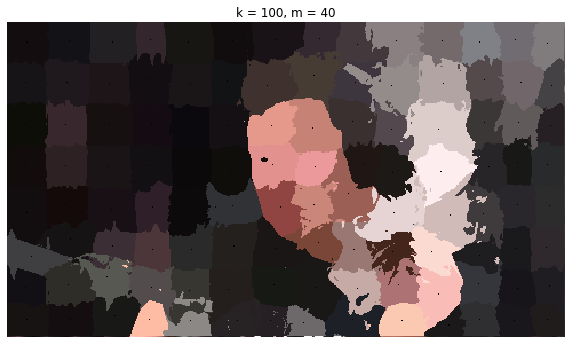

In [ ]:
k100m40 = SLIC(path = 'data/elon.png', k = 100, m = 40, maxiter = 7)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("k = 100, m = 40")
plt.imshow(k100m40)

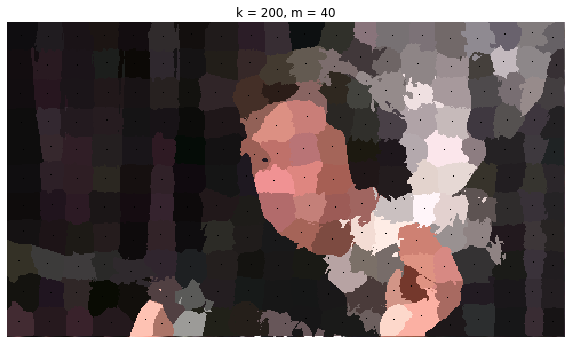

In [ ]:
k200m40 = SLIC(path = 'data/elon.png', k = 200, m = 40, maxiter = 7)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("k = 200, m = 40")
plt.imshow(k200m40)

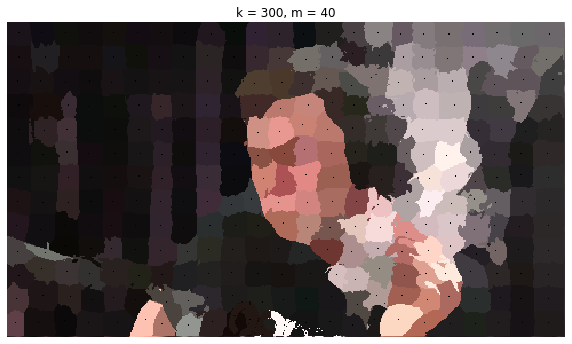

In [ ]:
k300m40 = SLIC(path = 'data/elon.png', k = 300, m = 40, maxiter = 7)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("k = 300, m = 40")
plt.imshow(k300m40)

We observe from the above images, that as the number of clusters $k$ is increased, the segmneted image captures more and more details (since clearly, more clusters can help show fine parts of the image). At the same time (as mentioned in the previous problem), inreasing the compactness parameter increases the emphasis on spatial proximity, which in turn increases the compactness of the clusters and gives a more even and ordered look to the image. The segmented image with $k=300$ and $m=40$ matches the one in the problem set very well.